# Machine Learning Demo

This notebook aims at giving you a basic idea of what machine learning can and cannot do as well as some insight on how it does it.

Author: Leo Marco Serena

date: september 2022

This notebook is freed to be used, shared and modified by anyone.

## Imports

### Local

### External

In [1]:
import os
import time
from typing import List, Optional, Dict, Union, Callable
import gc
from datetime import timedelta

# for progress bar
from tqdm import tqdm
# Vectorialization library
import numpy as np
# Dataframes for data managing
import pandas as pd
# plots
import matplotlib.pyplot as plt

import random

random.seed(69)
np.random.seed(69)

## Introduction

Machine Leaning is nothing more than a modern way of doing a specific branch of statistics named modelling. The idea is the following: given a set of data comming from a specific distribution, i.e. medical records, images of cats and dogs, etc., we want to build a model or a function that when feeded with the data and the wanted results, learns the underlying distribution that links the input to the output.

For example say we have a set of images of cat and dogs labelled (i.e. we have for every image the answer if it is a cat or a dog). We create a function $F: image \rightarrow \{cat, \ dog\}$ that given a non labelled image, can determine if the image is actually a cat or a dog.

We *know* there is a link between the input image and the answer since us humans are able to find what makes a cat and what makes a dog from looking at it.

Our model will have what we call *parameters* (in machine learning their often called *weights*). The whole goal is to make the model learn the best parameters given the sample data, this is why we call this machine learning.

## Data Preprocessing

### Data Generation

We start by generating some fake toy data.



Suppose that for a given entry (a data point) we have two values (features). For example assume that we have a bunch of individuals that have a heigth and a weight. On top of that, assume that we know their sex.

We would like, given some new data, determine, given a weight and a height, if it is a female or a male.

We model this by two Normal distributions and we label males -1 and females 1

We can generate such data for $N$ samples like this:

- We generate N random samples as exlained above for 2 classes independent
- We attrubute to them the labels -1 and 1. Thus our data will look like:
    [[1.123,2.43,-1],[2.33,3.342,1],[[4.3,3.32,1]], ...]
    One of these arrays will be a sample and the last element of an inner array its label (-1 or 1)

Let's say we have a bunch of data and we would like to analyse it, to do some statistics. To keep it easy, let's start with a very simple dataset consisting of point in a 2D space normaly distributed$^1$ comming from two sources of different means$^2$ and variances$^3$.

$$
    1: X \sim \mathcal{N}(\mu, \sigma) \rightarrow  p_X(x) = \frac{1}{\sqrt{2 \pi}} e^\frac{-(x - \mu)^2}{2\sigma^2}
$$

$$
    2: E[X] \doteq \int x * p_X(x) \ dx = \mu
$$

$$
    3: Var[X] \doteq \int p_X(x) * (E[X] - x)^2 = E[X^2] - E[X]^2 = \sigma^2
$$

![normal discribution](https://cdn.scribbr.com/wp-content/uploads/2020/10/standard-normal-distribution-1024x633.png)

In [2]:
def generate_normal_data(
    mu : float, 
    sigma : float, 
    N : int, 
    D : int,
    label : int
):
    data = np.random.normal(mu, sigma, size = (D, N))
    labels = np.array(data.shape[0] * [[label]])
    return np.concatenate((data.T, labels.T)).T

In [3]:
mu_x, sigma_x = 5, 1.2
mu_y, sigma_y = 10, 1.2

N = 200

# We generated 200 samples of class A and 200 of class B.
# We then concatenate them.
data_X = generate_normal_data(mu_x, sigma_x, 2, N, 0)
data_Y = generate_normal_data(mu_y, sigma_y, 2, N, 1)

data = np.concatenate((data_X, data_Y))

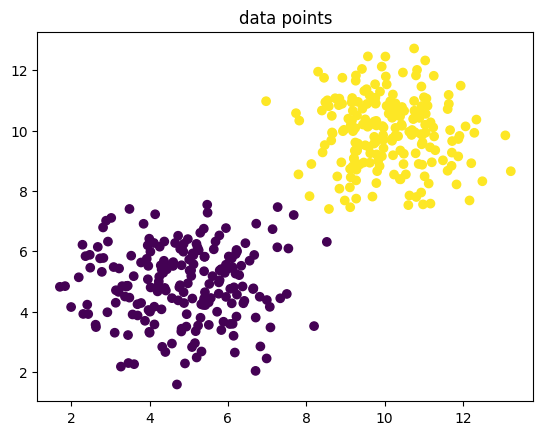

In [4]:
plt.title('data points')
plt.scatter(data[:,0], data[:,1], c = data[:,2])
plt.show()

### A word on numpy

In [5]:
# We simply generate some random long arrays
A_np = np.random.normal(0, 1, 1000000)
B_np = np.random.normal(0, 1, 1000000)
A_list = list(A_np)
B_list = list(B_np)

Before we continue, a word about performance and on numpy in general. numpy is an open source [github](https://github.com/numpy/numpy) python library than makes mathematical process involving arrays way faster.
But be aware of what it does.

First of all, let's take a simple example. Suppose you have two array of numbers and want a pairwise addition$^1$ and vector product$^2$.

$$
1: (\vec{u} + \vec{v})_i = u_i + v_i
$$

$$
2: \vec{u}^{T} \vec{v} \doteq \sum_{i=1}^N u_i * v_i = u_1 * v_1 + u_2 * v_2 + ... + u_N * v_N
$$

Note that for a column vector

$$
\vec v = \pmatrix{1 \\ 2 \\ 3}
$$
we have
$$
\vec v^{T} = \pmatrix{1\ 2\ 3}
$$

In pure python we would do something like that:

In [6]:
def add_for(a, b):
    return [a_ + b_ for a_,b_ in  zip(a,b)]

def product_for(a, b):
    return sum([a_ * b_ for a_,b_ in zip(a,b)])
        
%timeit add_for(A_list, B_list)
%timeit product_for(A_list, B_list)

80.1 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
110 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's see what numpy can do for us:

In [7]:
def add_vect(a, b):
    return a + b

def product_vect(a, b):
    return a @ b

%timeit add_vect(A_np, B_np)
%timeit product_vect(A_np, B_np)

2.48 ms ± 99.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
148 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


that was blazin' fast! Now you should be convinced that for large operations on arrays, numpy is times faster...

But be careful: the following examples will show you to be concerned on how to use numpy. For example if we want to cumpute the MSE$^{1}$ (Mean Squared Error) between two arrays (what it means is not yet important).

$$
1 : MSE(\vec u, \vec v) \doteq E[|| \vec u - \vec v||^2] = \frac{1}{N}\sum_{i=1}^N (u_i - v_i)^2
$$

In [8]:
def MSE_for(a, b):
    """
    naive implementation using for loop
    """
    return sum([((a_ - b_) ** 2) / len(a) for a_, b_ in zip(a,b)])

def MSE_vect0(a, b):
    """
    Implementation using the np.power method of numpy
    """
    return np.mean(np.power((a-b), 2))

def MSE_vect1(a, b):
    """
    Implementation using the fact that (a-b)^2 = a^2 + b^2 -2ab
    """
    return np.mean(a ** 2 + b ** 2 - 2 * a * b)

def MSE_vect2(a, b):
    """
    Implementation using the multiplication and np.mean method
    """
    return np.mean((a-b) * (a-b))

def MSE_vect3(a, b):
    """
    Implementation using the ** 2 power of python
    """
    return np.mean((a-b) ** 2)

def MSE_vect4(a, b):
    """
    Implementation using a temporary variable
    """
    e = (a-b)
    return e @ e / a.shape[0]

In [9]:
%timeit MSE_for(A_np, B_np)
%timeit MSE_for(A_list, B_list)
%timeit MSE_vect0(A_np, B_np)
%timeit MSE_vect1(A_np, B_np)
%timeit MSE_vect2(A_np, B_np)
%timeit MSE_vect3(A_np, B_np)
%timeit MSE_vect4(A_np, B_np)
# frees memory and calls garbage collector manually
del A_np, B_np, A_list, B_list
gc.collect()

314 ms ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
270 ms ± 7.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.4 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.4 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.6 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.75 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3

As we can see numpy greatly imporves our computation time, but some comments must be made.

First we can see that using random access on a numpy array is __solwer__ than for normal arrays (we can see the difference between the for loop on a regular array and a numpy array). numpy uses indexing in the background to avoid actually changing your arrays in memory. This makes thinks faster when accessing say a slice: ```A[:,3]``` but for many accesses this is actually slower.

Then we notice that the implementation using the np.power is the slowest of the numpy implementations. This is due to the fact that some operations are performed at processor level and are as fast as can be, so carefully using the right functions is crutial. And we can see it by noticing that the ```x ** 2``` implementation is way faster.

Finally we can see that that perhaps unexpectedly the last function is almost twice as fast as the previous one. In this implementation we make use of the fact that when we compute the intermediate value $e$, it already is close to the processor and then we perform a very fast operation ```e @ e``` (which is a numpy notation for the vector product $\vec{e}^{T} \vec{e}$)
and we don't need to perform an average operation which is slower, we only need to divide by the number of elements (Note the use of the ```.shape``` property. This is because a numpy array is actually a matrix and thus has several dimentions)

So as we can see many implementations can have many different complexities for a same mathematical expression.

On top of that, below is a small tip to apply an operation on arrays that don't have the same dimentions:

In [10]:
a = np.array([
    [1,2,3],
    [1,2,3],
    [1,2,3],
    [1,2,3]
])

b = np.array([1,2,3,4])

print(a + b[:, np.newaxis])
print(a * b[:, np.newaxis])

[[2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]
[[ 1  2  3]
 [ 2  4  6]
 [ 3  6  9]
 [ 4  8 12]]


### Data Cleaning

We now need to prepare our data a little more. This means standardize it and split it into 3 sets.

#### Standardization

Standardization makes, for a given feature, all elements centered and of same variation on average. This makes the data centered on 0 and of standard deviation 1. This is important as otherwise large values may have more importance than small values whereas maybe significance is in the smallest values.

In [11]:
def standardize(x : np.array):
    """
    normalization of the data. We substract the mean and divide by the
    standard deviaton.
    
    input
        x, data to be normalized
    output
        x, the normalized data
        """
    mean_x = np.nanmean(x, axis = 0)
    x = x - mean_x
    std_x = np.nanstd(x, axis = 0)
    x = x / std_x
    return x

#### Splitting

We now need to split our data in 3 parts. This is a standard manner to proceed. We will discuss this later but for now just think of it that way:

We want to *evaluate* how well our model performs. The problem is that if we test it with the data we used to train it with, then the model may just learn to return the same thing as we gave it and it didn't learn to *generalize*. This is why we evaluate the performance of our model using a *test set*. This is generally used to compare models between them.

In general, we also use a third set called *validation set* to evaluate how our model is doing *while we are training it*.

Of course, to avoid any bias in our data, we shuffle it such that it is on average equally distributed amond the 3 sets. Note that we also add an offset to the data (a collum full of ones), we will discuss that later on.

In [12]:
def split_standardize_shuffle(
    data : np.array,
    split = (0.15, 0.15),
    zero_one_labels = False
):
    """
    Takes as input a list of features and returns
    a test, validation and training data
    """
    copy = data.copy()
    np.random.shuffle(copy)
    l = copy.shape[0]
    a,b = int(l * split[0]), int(l * (split[0] + split[1]))
    test, val, train = copy[:a], copy[a:b], copy[b:]
    if zero_one_labels:
        # We do to not standardize the labels if we want 0-1 labels
        test = np.vstack((standardize(test[:, :2]).T, [test[:,2]])).T
        val = np.vstack((standardize(val[:, :2]).T, [val[:,2]])).T
        train = np.vstack((standardize(train[:, :2]).T, [train[:,2]])).T
    else:
        test = standardize(test)
        val = standardize(val)
        train = standardize(train)

        
    offset = np.array(test.shape[0] * [[1]])
    test = np.concatenate((offset.T, test.T)).T
    
    offset = np.array(val.shape[0] * [[1]])
    val = np.concatenate((offset.T, val.T)).T
    
    offset = np.array(train.shape[0] * [[1]])
    train = np.concatenate((offset.T, train.T)).T
    
    return test, val, train

test, val, train = split_standardize_shuffle(data, zero_one_labels=True)

In [13]:
print(test.shape[0])
print(val.shape[0])
print(train.shape[0])
print(data.shape[0])
assert test.shape[0] + val.shape[0] + train.shape[0] == data.shape[0]

60
60
280
400


Below we can see the standardized data. It looks the same but if you noticed the axis, it actually moved and the data have unit variance and null mean.

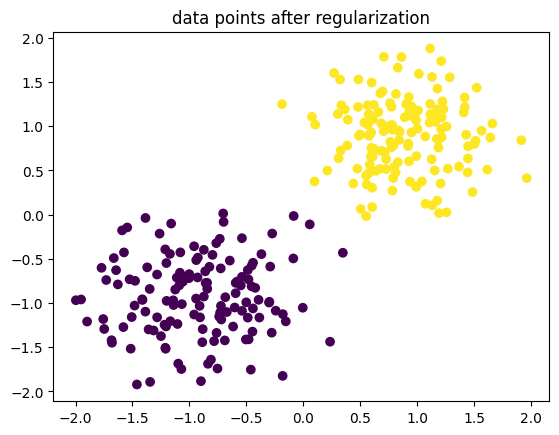

In [14]:
plt.title('data points after regularization')
plt.scatter(train[:,1], train[:,2], c = train[:,3])
plt.show()

Our data now looks like this:

In [15]:
# first column: offset
# second & third columns: features (x1,x2)
# fourth column: label
train[:3,:]

array([[ 1.        ,  1.00310148,  0.97249333,  1.        ],
       [ 1.        , -0.72490516, -0.60827526,  0.        ],
       [ 1.        ,  0.78231206,  0.2719424 ,  1.        ]])

## Modelling

### Evaluation

Let's now finally create our own model!

We will define a class that will implement a basic machine learning model, but first we need to decide what we want to optimize in a more (sorry) mathematical way.

Say we have a bunch of datapoints $X \in \mathbb{R}^{D \times N}$ (This means a matrix of $N$ datapoints of dimention $D$) and a set of corresponding labels $Y \in \{-1, 1\}^{N}$. Let $S = \{(\vec{x},y) \in X \times Y\}$ be the dataset with labels.

We will define the accuracy as the number of correct guesses over the number of samples.

i.e.

$$
accuracy(S) = \frac{1}{N} \sum_{\vec{x},y\ \in\ S} \mathbf{1} \{ model(\vec{x}) = y \}
$$

We will assume for now that this is our way of evaluating how well our model is performing.

In [16]:
def accuracy(predictions, labels):
    return np.mean(np.where(predictions == labels, 1, 0))

### The Perceptron

#### Description

We will start by the simplest neural network: the perceptron.

The perceptron is an implementation of a synapse, the same we have in our brains. Basically, given a set of inputs, it will *activate* or not depending on its own parameters. Does this ring a bell? This is exactly what we want to do with our toy data!

It looks like the following:

![perceptron](https://i0.wp.com/datascientest.com/wp-content/uploads/2021/04/illu_perceptron_blog-138.png?w=1024&ssl=1)

The perceptron has a list of parameters called weights, one per input feature. In our case the data has 3 features (two plus the offset) and thus our perceptron has 3 weights: $w_0$, $w_1$ and $w_2$.

For every feature, it multiplies the input feature with the corresponding weight and returns the sum of the results. Mathematically, given an input $\vec x = [x_0, x_1, x_2]^T$ (in the image these are $x,y,z$):

$$
perceptron(\vec x | \vec w) = \vec x^T \vec w \doteq \sum_{i=0}^2 x_i * w_i = x_0 * w_0 + x_1 * w_1 + x_2 * w_2
$$

So let's code that:

In [17]:
def perceptron(x, w):
    res = 0
    for x_, w_ in zip(x, w):
        res += x_ * w_
    return res

But since we have learned to use numpy to vectorialize products, it is a better idea to actually use the folowing function (given $x$ and $w$ are numpy arrays):

In [18]:
del perceptron

def perceptron(x, w):
    return x @ w

Let's try it:

In [19]:
x = np.array([1,2,3])
w = np.array([4,7,2])
# 1*4 + 2*7 + 3*2 = 4 + 14 + 6 = 24
perceptron(x,w)

24

#### Learning Algorithm

It works just fine. Now we need to make it actually modify $w$ such that it learns to classify our dataset. To do this, we need a learning process, i.e. an algorithm.

The proposed algorithm is the following:

Let $x_i$ be the $i$-th sample and $y_i$ be the label of sample $x_i$.

- init: $\vec w = \vec 0$
- do
    - for $i = 1 \rightarrow N $
        - $\tilde y_i \leftarrow \vec w^T \vec x_i$
        - if $y_i * \tilde y_i < 0$
            - $ \vec w \leftarrow \vec w + y_i * \vec x_i$
    - end for
- while still misscalssified samples

Ok so what happens? First notice that $\tilde y_i$ is nothing more than the output of the perceptron. We want it to be $-1$ when the correct label is $-1$ and $1$ when the correct label is $1$ right?. The output is a float number, so we map it to the closest value as a prediction. For example $7$ will be mapped to $1$ while $-0.4$ will be mapped to $-1$. More generally, the decision function is equal to

$$
\begin{equation}
    f(x) = 
    \begin{cases}
        1 & x > 0 \\
        -1 & x \leq 0
    \end{cases}
\end{equation}
$$

This means that a sample $x_i$ is missclassified *if it has a different sign than the correct label* and thus if the multiplication of the predicted label $\tilde y_i$ and the correct label $y_i$ is negative!

We now have to understand the update we perform on $\vec w$, and to do that we need to speak about one of the most (if not the most) important thing related to machine learning: GRADIENT DESCENT.

#### Gradient Descent

So what is GRADIENT DESCENT (or GD for short)? It is a method used to find the maxima or minimas of a given function; suppose we have a function $f(x)$ that has a global minima, fir example $f(x) = x^2$ but we don't actually know the function

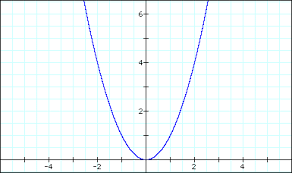

We can obviously see that the function has a global minima as $x=0$, but without knowing the actually function, how would we proceed?

A brute force approach would be to try random values of $x$ and pick the smallest one and tell this is the minima. While this could work for one dimension function such as our example, imagine if we have hundreds, thousands or more parameter, we would need to try a range of combination for all the parameters and that would be exponentially expenssive!

Another method is preferred. Suppose now we can determine the "slope" of the function on top of its value. What if continually go down the slope? Let's try it.

Beforehands we need to address the fact that a "slope" doesn't exist in mathematical terms, we rather talk about **derivatives** (and, for multi-parameters functions we talk about **gradients**).

We won't go over the definition of the derivative and simply say it returns a *direction* of a function at some point.

So for $f(x) = x^2$, by derivating, we obtain $\frac{\delta f(x)}{\delta x} = \frac{\delta x^2}{\delta x} = 2x$

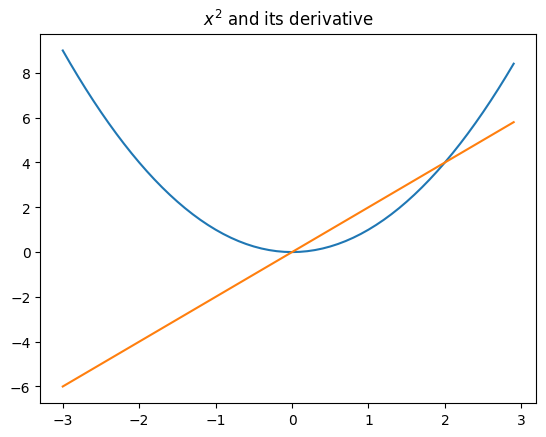

In [20]:
def f(x):
    return x ** 2

def df(x):
    return 2 * x

x_values = np.arange(-3, 3, 0.1)
plt.title('$x^2$ and its derivative')
plt.plot(x_values, f(x_values))
plt.plot(x_values, df(x_values))
plt.show()

As we can see the derivative is consitent with the intuition in the sense that while the slope become more and more *sloppy*, the derivative becomes larger and larger, and converselly and at 0 the value of the slope is null while the "direction" of the function is horizontal.

Now let's use our GD algorithm. We pick a random value and we go down the slope (so we substract the slope):

In [21]:
x = 2
print(x)
for i in range(10):
    x = x - df(x)
    print(x)

2
-2
2
-2
2
-2
2
-2
2
-2
2


Oups, doesn't seen to be working... why is that? Let's visualize it.

At $x = 2$ we have its derivative equal to $2x = 2*2 = 4$. Thus $x - 4 = -2$

Then we do the same and we get at $x = -2$, yielding $2 * x = 2 * (-2) = -4$ and we get $-2 - (-4) = 2$

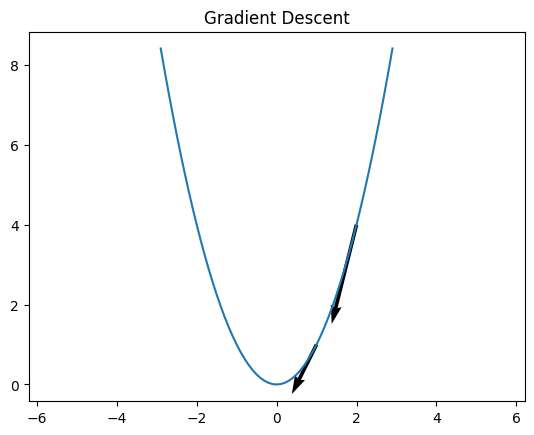

In [22]:
x_values = np.arange(-2.9, 3, 0.1)

plt.title('Gradient Descent')
plt.plot(x_values, f(x_values))

plt.axis('equal')

for x in range(1,3):
    plt.quiver(*[x, f(x)], -1, - df(x), scale = 20)
plt.show()

Basically the update we perform is way to big and we go **over** the minima! What can we do? A common method is to instead enforce small steps. i.e. use a *learning rate*. This means that we multiply the gradient by some arbitrary small value:

In [23]:
lr = 0.2

x = 2
print(x)
for i in range(10):
    x = x - lr * df(x)
    print(x)

2
1.2
0.72
0.432
0.2592
0.15552
0.09331199999999999
0.055987199999999994
0.033592319999999995
0.020155391999999994
0.012093235199999997


Would you look at that: after some iterations, we are very close to our goal!

And this is basically how gradient descent works, but instead of a function, we have a set of parameters and instead of a derivative we compute a gradient.

A **very** important remark is that the function we want to minimize must have a derivative, otherwise we can't make use of this method. 

Here is another example with another function for good measures: 

$$
f(x) = \frac{1}{4} x^4 - x^3 + x + 20
$$

$$
f'(x) = x^3 - 3 x^2 + 1
$$

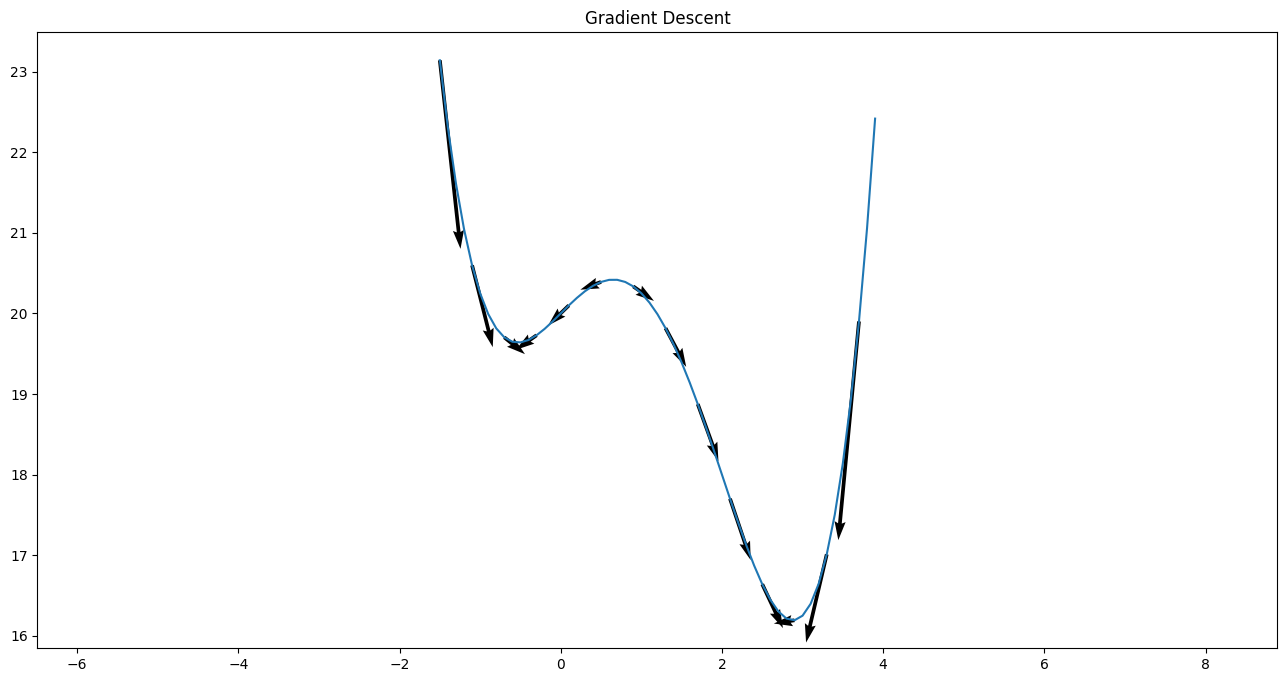

In [24]:
def f(x):
    return (x ** 4) / 4 - x ** 3 + x + 20

def df(x):
    return  x ** 3 - 3 * x ** 2 + 1
    
x_values = np.arange(-1.5, 4, 0.1)

plt.figure(figsize = (16, 8))
plt.title('Gradient Descent')
plt.plot(x_values, f(x_values))

plt.axis('equal')

for x in x_values[::4]:
    dx = -1 if df(x) > 0 else 1
    dy = -df(x) if df(x) > 0 else df(x)
    plt.quiver(*[x, f(x)], dx, dy, scale = 60, width = 0.003)
plt.show()

In [25]:
lr = 0.2

x = 2
print(x)
for i in range(10):
    x = x - lr * df(x)
    print(x)

2
2.6
2.9408000000000003
2.8431959269375997
2.8967093222279043
2.870050186187038
2.884134397426835
2.8768937720125716
2.880671948853751
2.8787152471788886
2.8797326322675962


In [26]:
lr = 0.2

x = -1
print(x)
for i in range(10):
    x = x - lr * df(x)
    print(x)

-1
-0.3999999999999999
-0.49119999999999997
-0.5227304402944
-0.5302152556086468
-0.5317266313237624
-0.5320193495362783
-0.5320755570182707
-0.5320863319004101
-0.5320883967642119
-0.5320887924437065


The last example raises a question: what if we are stuck in the local minima (in the graph at around $-1$)? Indeed, the gradient becomes $0$ at this point. How can we know there isn't another better solution? Indeed, if we are at $-1$, we see that if we go on the left along the function, the gradient gives us the oposite direction and same goes when going to the right. This is a local minima and depending from where we start the algorithm, we may never find the global minima at around $2.88$.

This is one of the biggest problem in machine learning and has to do with with what is called *optimization* and various learning algorithm with it with various techniques but all you have to know is that this is an active area of research.

#### Gradient Descent with Perceptron

Now let's come back to our perceptron and we can finally explain why we perform the step

$  \vec w \leftarrow \vec w + y_i * \vec x_i $

We used what we call in ML a *Loss function*, i.e. a derivable function that measures how poorly our model performs.
Our loss function here is simply:

$$
L(X | \vec w) = - \sum_{i \in \mathbf{M}} y_i * \vec x_i^T \vec w
$$

where $\mathbf{M}$ is the set of missclassified samples. The explanation comes from what we said earlier: a sample is misslabeled if $y_i * \vec x_i^T \vec w < 0$ and thus its oposite measures how poorly we perform and we want to *minimize* it.

Why not use Gradient Ascend and maximize  $y_i * \vec x_i^T \vec w$ then? First as a matter of convention and second it is better to consider the Loss as a number between $0$ and infinity where $0$ means we make no error.

For a single missclassified sample, we have:

$$
\ell (\vec x_i | \vec w) = - y_i * \vec x_i^T \vec w
$$

We thus have 
$$
\frac{\delta \ell (\vec x_i | \vec w))}{ \delta \vec w} = - y_i * \vec x_i
$$

Going down the gradient thus yields 

$$
w \leftarrow w - (- y_i * \vec x_i) = w + y_i * \vec x_i
$$

Time to implement it!

In [27]:
w = np.array([-1, 1])

def evaluate_perceptron(dataset, w):
    preds = perceptron(dataset[:, 1:3], w)
    preds = np.where(preds < 0, 0, 1)
    return accuracy(preds, dataset[:,3])

print(f"""
accuracy before training: {evaluate_perceptron(test, w) * 100} %""")

for x, y in zip(train[:, 1:3], train[:, 3]):
    prediction = perceptron(x, w)
    if y * prediction <= 0:
        w = w + y * x
        
print(f"""
accuracy after training: {evaluate_perceptron(test, w) * 100} %""")


accuracy before training: 46.666666666666664 %

accuracy after training: 100.0 %


Our perceptron learned really fast and the accuracy on the test set is getting better!

Now we ask ourselves: how do we go from a perceptron to huge models able to process images, video, sounds etc.? And how do we improve our score?

Let's first show the limitation of the perceptron. Indeed the perceptron can classify anything *as long as the dataset is lineraly separable*, this means that a hyperplane can fully separate the two classes (in 2D this means a line).

An example of non linearly separable dataset is the following

#### The XOR Problem

In [28]:
x = generate_normal_data(2, 1, 1, N, 0)
y = generate_normal_data(10, 1, 1, N, 0)
tmp = np.hstack((x, y))
data_0 = tmp[:, [0,2,3]]
x = generate_normal_data(10, 1, 1, N, 0)
y = generate_normal_data(2, 1, 1, N, 0)

tmp = np.hstack((x, y))
data_0 = np.vstack((tmp[:, [0,2,3]], data_0))

x = generate_normal_data(10, 1, 1, N, 1)
y = generate_normal_data(10, 1, 1, N, 1)
tmp = np.hstack((x, y))
data_1 = tmp[:, [0,2,3]]
x = generate_normal_data(2, 1, 1, N, 1)
y = generate_normal_data(2, 1, 1, N, 1)

tmp = np.hstack((x, y))
data_1 = np.vstack((tmp[:, [0,2,3]], data_1))

data = np.vstack((data_0, data_1))

test, val, train = split_standardize_shuffle(data, zero_one_labels=True)

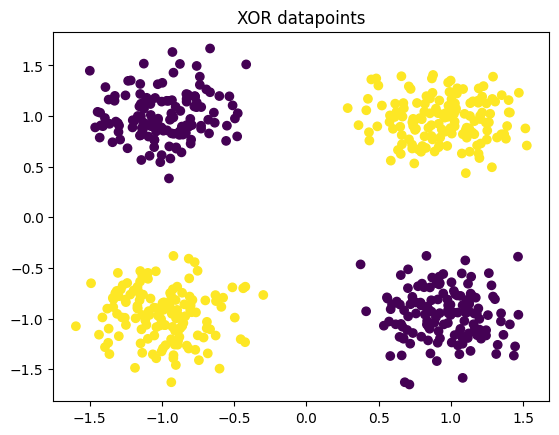

In [29]:
plt.title('XOR datapoints')
plt.scatter(train[:, 1], train[:, 2], c = train[:, 3])
plt.show()

If we try to classify the datapoints using a preceptron:

In [30]:
w = np.array([0,0])

for x, y in zip(train[:, 1:3], train[:, 3]):
    prediction = perceptron(x, w)
    if y * prediction <= 0:
        w = w + y * x

preds = perceptron(test[:, 1:3], w)
preds = np.where(preds < 0, -1, 1)
accuracy(preds, test[:,3])

0.25

mmh so what happened? Well try to put a line in the graph going through $(0,0)$ that separates completelly the two classes. Don't actually try, it is impossible. Even if we stacked several perceptrons to add more "depth" to our model this won't work:

In [31]:
w1 = np.array([0,0])
w2 = np.array([0,0])
w3 = np.array([0,0])

def stacked_perceptron(w1, w2, w3, x):
    z1 = perceptron(x, w1)
    z2 = perceptron(x, w2)
    z = np.array([z1, z2])
    return perceptron(z, w)

for x, y in zip(train[:, 1:3], train[:, 3]):
    prediction = stacked_perceptron(w1, w2, w3, x)
    if y * prediction <= 0:
        w = w + y * x
            
preds = perceptron(test[:, 1:3], w)
preds = np.where(preds < 0, -1, 1)
accuracy(preds, test[:,3])

0.30833333333333335

why is that? Well when you think about it, if we add perceptrons as we defines them earlier (a simple vector product) all we did were linar operations, i.e. multiplications between vectors!

If you set $W = [w_0 \ w_1]$, we have $\vec z_i = W^T \vec x_i$ and $\tilde y = \vec z^T \vec w_2$ which yields:

$$
\tilde y = \vec z^T \vec w_2 = (W^T \vec x)^T \vec w_2 = \vec x^T W \vec  w_2 = \vec x^T \vec a
$$

Since 

$$ 
\vec a = W \vec w_2 = \pmatrix{w_{0,0} \ w_{1,0} \\ w_{0,1} \ w_{1,1} \\ w_{0,2} \ w_{1,2}} \pmatrix{w_{2,0} \\ w_{2,1}} = \pmatrix{w_{2,0} * w_{0,0} + w_{2,1} * w_{1,0} \\ w_{2,0} * w_{0,1} + w_{2,1} * w_{1,1} \\w_{2,0} * w_{0,2} + w_{2,1} * w_{1,2}}
$$

an $\vec a$ is nothing more than a vector, this means that our model is as *strong* as a unique perceptron!

This is why we introduce what we call a **non-linearity**. This means that we pass every linar operation output to a function that is not linear, a function that will decide *whether the output information is relevant or not*. This is the same mechanism we have in our brain cells, if the input stimulis are strong enough, we *fire* to the next, and the decision is weighted on all the input stimulis. This means every cell learns to evaluate the correct relevance (or weight) of each individual input.

To introduce a non-linearity, we will use a very simple and common function: the ReLU (Rectified Linear Unit). It does the following:

$$
\begin{equation}
    ReLU(x) = 
    \begin{cases}
        0 & x \leq 0 \\
        x & x > 0
    \end{cases}
\end{equation}
$$

By the way this kind of functions are called **activation funtions**

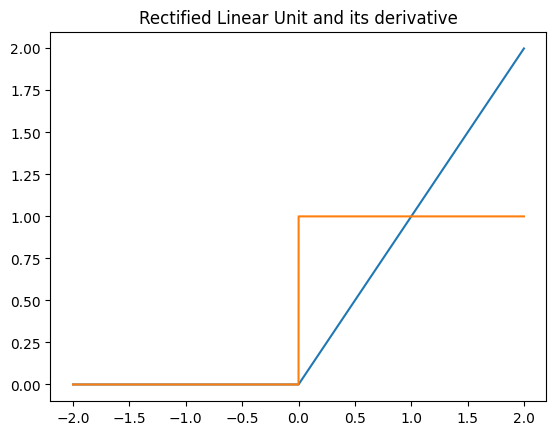

In [32]:
def relu(x):
    return np.where(x < 0, 0, x)

def drelu(x):
    return np.where(x < 0, 0, 1)

X = np.arange(-2, 2, 0.001)
plt.title('Rectified Linear Unit and its derivative')
plt.plot(X, relu(X))
plt.plot(X, drelu(X))
plt.show()

To train a single perceptrons such that they can classify the XOR layout is not that easy. But let's nonetheless show a proof that this is possible:

We will use 3 perceptrons with 3 activation functions.
Let 
$
X = \pmatrix{1 \ 1 \\ 1 \ 0 \\ 0 \ 1 \\ 0 \ 0}
$
and 
$ Y = \pmatrix{0 \\ 1 \\ 1 \\ 0} $.

In [33]:
X = np.array([
    [1,1],
    [1,0],
    [0,1],
    [0,0]
])
Y = np.array([0,1,1,0])

With 3 perceptrons we would have:

$$
\begin{equation}
model(\vec x) = 
\begin{cases}
    0, \vec w_3^T \vec a + b_3 \le 0 \\
    1, \vec w_3^T \vec a + b_3 > 0 \\
\end{cases}
\end{equation}
$$

where $ a_1 = ReLU(\vec w_1^T \vec x + b_1) $ and $ a_2 = ReLU(\vec w_2^T \vec x + b_2) $

Note that we added a $b$ parameter (tunnable as much as $w$). This basically serves as an offset such that our line is able to not go through $(0,0)$.

A possible solution is the following:

$$
w_1 = [2,2], b_1 = -3 \\
w_2 = [2,2], b_2 = -1 \\
w_3 = [-3,1], b_3 = -1/2
$$

In [34]:
w1 = np.array([2,2])
b1 = -3
w2 = np.array([2,2])
b2 = -1
w3 = np.array([-3,1])
b3 = -0.5

H1 = perceptron(X, w1) + b1
H2 = perceptron(X, w2) + b2
H = np.concatenate((H1, H2)).reshape(2,4).T
print(H)
A = relu(H)
print(A)
Z = perceptron(A, w3) + b3
print(Z)
print(np.where(Z < 0, 0, 1))

[[ 1  3]
 [-1  1]
 [-1  1]
 [-3 -1]]
[[1 3]
 [0 1]
 [0 1]
 [0 0]]
[-0.5  0.5  0.5 -0.5]
[0 1 1 0]


What it basically does is use the first 2 perceptrons to *remap* the original dataset into a lineariy separable dataset.
Once the data is linearly separable, it is easy for a perceptron to define a spearating function.

Hereafter is shown the datapoints as well as the linar functions of the slopes of the parameters $w$.

So for example, if we have $w = [2,2]$ and $b = -1$, we would have:

$w_1 * x + w_2 * y + b = 0$ implying a slope $y = - x * \frac{w_1}{w_2} - \frac{b}{w_2} = -x + 0.5$

(note that in the following remapping, $x_1$ is behind $x_2$)

![OneLayerPerceptron](./imgs/OnelayerPerceptron.jpg)

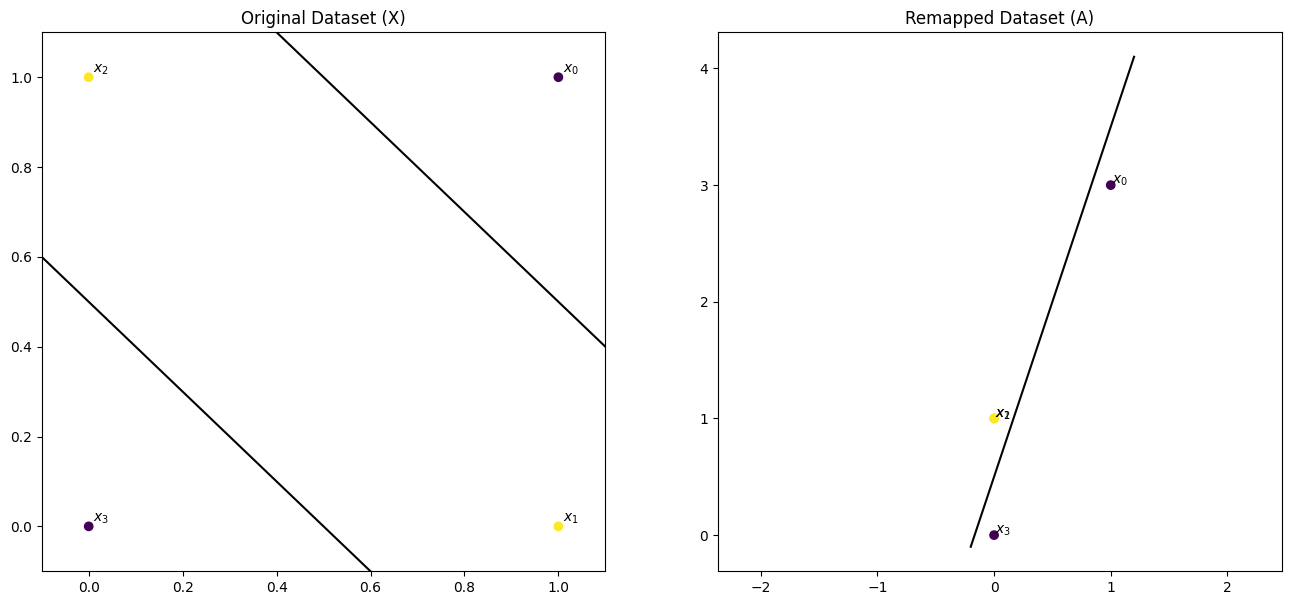

In [35]:
def plot_w(ax, w, b):
    ax.plot(
        [1.2, -0.2], 
        [1.2 * (-w[0] / w[1]) - b / w[1], - 0.2 * (-w[0] / w[1]) - b / w[1]],
        color = 'black'
    )

fig, axs = plt.subplots(1,2, figsize = (16, 7))
ax1 = axs[0]
ax1.set_title('Original Dataset (X)')
ax1.scatter(*X.T, c = Y)
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
for i,x in enumerate(list(X)):
    ax1.annotate(f'$x_{str(i)}$', (x[0] + 0.01, x[1] + 0.01))
plot_w(ax1, w1, b1)
plot_w(ax1, w2, b2)
    
ax2 = axs[1]
ax2.set_title('Remapped Dataset (A)')
ax2.axis('equal')
ax2.scatter(*A.T, c = Y)
ax2.set_xlim([-0.1, 0.2])
for i,x in enumerate(list(A)):
    ax2.annotate(f'$x_{str(i)}$', (x[0] + 0.01, x[1] + 0.01))
plot_w(ax2, w3, b3)
plt.show()

Resumming our understanding of the ReLU function, this means that our perceptrons will *fire* only when the weighted sum of their inputs is greater than 0. 

Note that the function is derivable everywhere except on 0. Without introducing the notion of sub-gradients, we will simply say that at 0 the gradient equals 0. This isn't a problem as it is continuous with the left-end and that it is prectically impossible to have an exactly equal to 0 input.

Our new perceptron will thus do the following:

$$
perceptron(\vec x | \vec w) = ReLU(\vec x^T \vec w) =     
    \begin{cases}
        0 & \vec x^T \vec w \leq 0 \\
        \vec x^T \vec w & \vec x^T \vec w > 0
    \end{cases}
$$

### Multi-Layered Perceptron (MLP)

Now that we saw how several perceptrons work together and that the more we add, the more complex data we can analyse and on top of that we know how to find the best parameters using Gradient Descent, we can build our own huge stack of interconnected perceptrons and test it out!

To do this, we will simply stack up perceptrons one after the other and vectorize the gradient descent step. The following section explains the mathematical foundation of how to compute gradients in deep neural network and is not necessary to understand the rest.

#### Mathematical interlude

The following section serves to explain mathematically how to compute parameters gradients for the bravest readers.

Suppose we will use a different loss that is more stable (even if not suited for classification problems), the MSE

$$
MSE(y, \tilde y) = E[||y- \tilde y||^2]
$$

Our algorithm would then look like the following:

- init: $W = \pmatrix{\vec w_0,\ \vec w_1,\ \vec w_2}, \vec u = \vec w_3$ randomly
- for $n \in \{1,2,...,M\}$
    - for $i = 1 \rightarrow N $
        - $\vec z \leftarrow ReLU(W^T x_i)$
        - $\tilde y_i \leftarrow = \vec z^T \vec u$
        - compute MSE loss: $ (y - \tilde y)^2 $
        - backpropagate
    - end for
- end for

How do we perform the gradient step? We need, for every parameter, the corresponding derivative.

One important mathematical rule (not proved here) that we use to find the derivate of a specific parameter is what we call **the chain rule**. it basically says:

$$
\frac{\delta z(x)}{\delta x} = \frac{\delta z(y)}{\delta y(x)} * \frac{\delta y(x)}{\delta x}
$$

So for example let $ f(x) = cos(x^2) $
Then we would have

$$
\begin{align}
    \frac{\delta f(x)}{\delta x} & = \frac{\delta cos(x^2)}{\delta x} \\
                                 & = \frac{\delta cos(x^2)}{\delta x^2} * \frac{\delta x^2}{\delta x} \\
                                 & = sin(x^2) * 2x \\
\end{align} 
$$

In our case we have ($\ell$ is the loss for a single sample):

$$
\begin{align}
    \frac{\delta \ell(\tilde y | W)}{\delta \vec w_3} 
    & = \frac{\delta (y - \tilde y)^2}{\delta \vec w_3} \\
    & = \frac{\delta (y - \tilde y)^2}{\delta \tilde y} * \frac{\tilde y}{\delta \vec w_3} \\
    & = - 2 (y - \tilde y) * \frac{\vec w_3^T \vec z}{\delta \vec w_3} \\
    & = - 2 (y - \tilde y) * \vec z
\end{align}
$$

and for $W$:

$$
\begin{align}
    \frac{\delta \ell(\tilde y | W)}{\delta W} 
    & = \frac{\delta (y - \tilde y)^2}{\delta \vec W} \\
    & = \frac{\delta (y - \tilde y)^2}{\delta \tilde y} * \frac{\delta \tilde y}{\delta \vec W} \\
    & = - 2 (y - \tilde y) * \frac{\delta \vec w_3^T \vec z}{\delta \vec W} \\
    & = - 2 (y - \tilde y) * \frac{\delta \vec w_3^T \vec z}{\delta \vec z} * \frac{\delta \vec z}{\delta \vec W} \\
    & = - 2 (y - \tilde y) * \vec w_3 * \frac{\delta ReLU(W^T \vec x_i)}{\delta \vec W} \\
    & = - 2 (y - \tilde y) * \vec w_3 * \frac{\delta ReLU(W^T \vec x_i)}{\delta W^T \vec x_i} * \frac{\delta W^T \vec x_i}{\delta W} \\
    & = - 2 (y - \tilde y) * \vec w_3 * \begin{cases} 0 & W^T \vec x_i \leq 0 \\ W^T \vec x_i & W^T \vec x_i > 0 \end{cases} * \vec x_i \\
\end{align}
$$

Note that the relu is perform *row-wise*.

On thing we can notice is that there is a common part to both computed gradients: $- 2(y - \tilde y)$. And this term would *propagate* further back in the weights. So to avoid to recompute these steps, we instead keep intermediate results and process the gradients sequentially avoiding any recomputations. This is called *backpropagation*.

#### End of the mathematical interlude

----------

#### Implementation

Hereafter is coded an MLP using vectorized gradient as well as some more improvements listed bellow. These are for people wanting to go further in their understanding of Machine Learning.

- **Sigmoid activation function**

    The sigmoid function is another activation function which is better to approximate probabilities.
    Its definition is 
    
    $$
    \sigma(x) = \frac{e^x}{e^x + 1} 
    $$
    
    Since the numerator is always positive and the denominator is always at most 1 unit more than the numerator, the result always is comprised between 0 and 1.
    
    
- **Batch gradient**
    
    Basically, the strict definition of the Gradient Descent is that we compute the average of the gradient for all samples and perform a single optimization step. On the other hand, stochastic Gradient Descent performs an optimization step for every sample. The thing is that the first is very accurate but very slow (as we have to go throug the whole dataset) and the second has a huge variance but is very fast. We thus do something inbetween, we randomly split the training data into *batches* at every pass in the data. Note that a *pass* is called an *epoch*
    
    
- **Regularization**
    
    One of the biggest concern of statistical modelling is to find the sweet spot right between underfitting the data and overfitting the data. We want the model to have a general knowledge of the data and understand the underlying statistical relationship such that it can process new data. This is done by adding a value penalizing too large weights by adding a norm term to the Loss function. For a MSE loss this would yield:
    
    $$
    L(X|W) = MSE(Y, \tilde Y) + \frac{\lambda}{p}||W||_p^p
    $$
    
Where often $p =2$ and $\lambda$ is a hyperparameter.

- **Hyperparameters**

   These are paramters that are not learned through training and are used to configure the training. For example the learning rate, the regularization weight and norm etc.
   
   
- **BinaryCrossEntropy loss**

    This is a loss that is often used to improve gradient for binary classification tasks.

In [36]:
def relu(z):
    """
    Rectified Linear Unit function
    """
    return np.where(z < 0, 0, z)

def relu_gradient(z):
    """
    Gradient of the ReLU function
    """
    return np.where(z < 0, 0, 1)

def sigmoid(z):
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z):
    """
    Gradient of the Sigmoid function
    """
    return sigmoid(z) * (1 - sigmoid(z))

def BCE_loss(y, y_pred, eps = 0):
    return - np.mean(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))


def BCE_gradient(y, y_pred):
    """
    Binary Cross-Entropy loss
    """
    return -y/y_pred + (1-y)/(1-y_pred)

def MSE_loss(y, y_pred):
    e = (y - y_pred)
    return e.T @ e / y.shape[0]

def MSE_gradient(y, y_pred):
    return - 2 * np.mean(y - y_pred)

In [37]:
class Activation:
    def __init__(self, f, df):
        self.f = f
        self.df = df
    
    def __call__(self, x):
        return self.f(x)
    
    def gradient(self, x):
        return self.df(x)
    
        
class Layer:
    def __init__(
        self, 
        dim_0 : int,
        dim_1 : int, 
        activation : Activation
    ):
        """
        Layer class that updates its weights and backpropagates
        """
        # Init parameters
        self.w = np.random.randn(dim_0, dim_1) / np.sqrt(dim_0)
        self.b = np.zeros(dim_0)
        # Init parameters gradients
        self.w_grad = None
        self.b_grad = None
        # init intermediate values
        self.a_prev = None
        self.a = None
        self.z = None
        self.activation = activation

    def __call__(self, a):
        return self.feed_forward(a)
        
    def feed_forward(self, a):
        """
        Performs the following operations:
        z = a[-1] @ w + b
        a = f(z)
        return a
        
        There are 2 values for a since we need to keep the previous value for backpropagation
        """
        self.a_prev = a
        if len(a.shape) == 1:
            # for batch_size 1
            self.z = np.dot(self.w, a) + self.b
        else:
            self.z = np.dot(self.w, a) + np.tile(self.b, (a.shape[1],1)).T
        self.a = self.activation(self.z)
        return self.a
    
    def back_propagate(self, grad):
        """
        Performs the corresponding backpropagation for all parameters and returns the gradient
        for the previous layer (cf. chain rule).
        """
        grad = grad * self.activation.gradient(self.z)
        self.w_grad = grad @ self.a_prev.T
        self.b_grad = np.sum(grad, axis = 1)
        return (grad.T @ self.w).T
    
class Loss:
    def __init__(self, f : Callable, df : Callable):
        if self.__class__ == 'Loss':
            raise NotImplementedError
        self.f = f
        self.df = df
        
    def __call__(self, ground_truth, predictions):
        return self.f(ground_truth, predictions)
    
    def gradient(self, ground_truth, predictions):
        return self.df(ground_truth, predictions)
    
class BCELoss( Loss ):
    def __init__(self):
        super().__init__(BCE_loss, BCE_gradient)
        
class MSELoss( Loss ):
    def __init__(self):
        super().__init__(MSE_loss, MSE_gradient)

In [38]:
class MLP:
    """
    Multi-layer perceptron class.
    """
    def __init__(
        self, 
        dim : List[int], 
        activations : List[Activation],
        loss : Loss
    ):
        if len(dim) - 1 != len(activations):
            raise ValueError("The number of activation functions should be L-1 where L is the number of layers")
        self.layers = []
        for n in range(len(dim)-1):
            self.layers.append(Layer(dim[n + 1], dim[n], activations[n]))
        self.loss = loss
    
        
    def feed_forward(self, X):
        a = X
        for layer in self.layers:
            a = layer(a)
        return a[0]
    
    def __call__(self, X):
        return self.feed_forward(X)
    
    def back_propagate(self, y_pred, y):
        """
        Computes the gradient for every paramters in the model
        """
        grad = self.loss.gradient(y, y_pred)
        for layer in np.flip(self.layers):
            grad = layer.back_propagate(grad)
        
            
    def gradient_descent_step(self, gamma, weight_decay):
        for l in self.layers:
            l.w -= (l.w_grad + l.w * weight_decay) * gamma
            l.b -= (l.b_grad + l.b * weight_decay) * gamma
            
    def train(
        self, 
        X : np.array, Y : np.array,
        X_val : np.array, Y_val : np.array,
        batch_size : int, 
        num_epochs : int, 
        gamma : float, 
        weight_decay : float, 
        number_of_loss_computations = 5,
        stop_when_not_decreasing = True
    ):
        """
        (X, Y) : np.arrays with X being the samples of shape (N, D) and Y the labels of shape (N,)
        (X_val, Y_val) : np.arrays for training validation
        batch_size : The number of elements in a single batch of training
        num_epochs : The maximum number of times we iterate over the whole dataset
        gamma : The learning rate
        weight_decay : The factor for the regularization factor
        """
        if X.shape[0] != Y.shape[0]:
            raise ValueError("The number of samples and labels are not the same")
        prev_loss = np.inf
        losses, val_losses = [], []
        N, D = X.shape
        n_batches = int(N / batch_size)
        idxs = np.arange(N)
        for i in tqdm(range(num_epochs)):
            if i % 1 == 0:
                Y_pred = self(X.T)
                loss = self.loss(Y, Y_pred)
                losses.append(loss)
                Y_pred_val = self(X_val.T)
                val_loss = self.loss(Y_val, Y_pred_val)
                val_losses.append(val_loss)
            np.random.shuffle(idxs)
            for k in range(n_batches):
                tmp = idxs[int(batch_size * k):int(batch_size * (k+1))]
                X_batch = X[tmp]
                y_batch = Y[tmp]
                y_pred = self.feed_forward(X_batch.T)
                self.back_propagate(y_pred, y_batch)
                self.gradient_descent_step(gamma / len(X_batch), weight_decay)
            if prev_loss > loss:
                prev_loss = loss
            elif stop_when_not_decreasing:
                break
                
        plt.plot(losses)
        plt.plot(val_losses)
        plt.show()

    def predict(self, X):
        y = self.feed_forward(X.T)
        return np.where(y < 0.5, 0, 1)
    
    def accuracy(self, X, Y):
        return 1 - np.mean(np.abs(self.predict(X) - Y))

In [39]:
E = 500

X = train[:, :3]
Y = np.where(train[:, 3] < 0.5, 0, 1)

X_val = val[:, :3]
Y_val = np.where(val[:, 3] < 0.5, 0, 1)

ReLU = Activation(relu, relu_gradient)
Sigmoid = Activation(sigmoid, sigmoid_gradient)

BCE = BCELoss()

mlp = MLP(
    dim = [3, 5, 1],
    activations = [ReLU, Sigmoid],
    loss = BCE
)
mlp.accuracy(X_val, Y_val)

0.5166666666666666

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 492.89it/s]


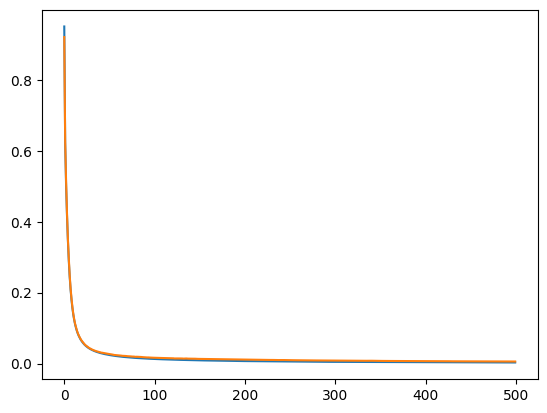

Accuracy : 1.0


In [40]:
mlp.train(
    X, Y,
    X_val, Y_val,
    batch_size = 32,
    num_epochs = E,
    gamma = 0.1,
    weight_decay = 0.01
)
print(f"""Accuracy : {mlp.accuracy(X_val, Y_val)}""")

As we can see, both the losses of the train and validation loss decrease steadily and our model perfectly classifies the dataset.

https://www.kaggle.com/datasets/uciml/mushroom-classification?resource=download

In [41]:
path = os.path.join('datasets', 'mushrooms.csv')
mushrooms = pd.read_csv(path)
mushrooms.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Data Preparation

We start by converting our data into numerical values

In [42]:
to_remove = []
for c in mushrooms.columns:
    to_num = {x : i for i, x in enumerate(np.unique(mushrooms[c]))}
    if len(to_num) == 1:
        to_remove.append(c)
    mushrooms[c] = mushrooms[c].map(to_num)
    
# We remove the values that have a single value as they bring no additionnal information
mushrooms = mushrooms.drop(to_remove, axis = 1)
mushrooms.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


We then do the same we did previously, i.e. we normalize and split it

In [43]:
a,b = 0.15, 0.1
N = len(mushrooms)
A, B = int(a * N), int((a + b) * N)
idxs = np.arange(len(mushrooms))
np.random.shuffle(idxs)

mushroom_test = idxs[:A]
mushroom_val = idxs[A:B]
mushroom_train = idxs[B:]

mushroom_test = mushrooms.loc[mushroom_test]
mushroom_test_Y, mushroom_test_X = mushroom_test.iloc[:,:1].to_numpy().flatten(), mushroom_test.iloc[:,1:]
mushroom_test_X = standardize(mushroom_test_X).to_numpy()

mushroom_val = mushrooms.loc[mushroom_val]
mushroom_val_Y, mushroom_val_X = mushroom_val.iloc[:,:1].to_numpy().flatten(), mushroom_val.iloc[:,1:]
mushroom_val_X = standardize(mushroom_val_X).to_numpy()

mushroom_train = mushrooms.loc[mushroom_train]
mushroom_train_Y, mushroom_train_X = mushroom_train.iloc[:,:1].to_numpy().flatten(), mushroom_train.iloc[:,1:]
mushroom_train_X = standardize(mushroom_train_X).to_numpy()

assert len(mushroom_test_X) + len(mushroom_val_X) + len(mushroom_train_X) == len(mushrooms)
assert len(mushroom_test_Y) + len(mushroom_val_Y) + len(mushroom_train_Y) == len(mushrooms)

In [44]:
ReLU = Activation(relu, relu_gradient)
Sigmoid = Activation(sigmoid, sigmoid_gradient)

BCE = BCELoss()

mlp = MLP(
    dim = [mushroom_train_X.shape[1], 3, 1],
    activations = [ReLU, Sigmoid],
    loss = BCE
)
mlp.accuracy(mushroom_test_X, mushroom_test_Y)

0.367816091954023

 21%|████████████████▋                                                               | 104/500 [00:02<00:08, 45.66it/s]


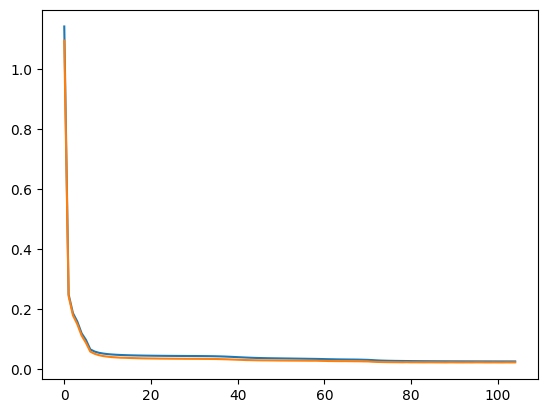

Accuracy : 0.9893267651888341


In [45]:
mlp.train(
    mushroom_train_X, mushroom_train_Y,
    mushroom_val_X, mushroom_val_Y,
    batch_size = 32,
    num_epochs = E,
    gamma = 0.1,
    weight_decay = 0.01
)
print(f"""Accuracy : {mlp.accuracy(mushroom_test_X, mushroom_test_Y)}""")

https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study?resource=download


The wanted values is the G3 column. The description says that it is strongly connected to the G1 and G2 and would be more interesting to predict them without these info

In [56]:
path_maths = os.path.join('datasets', 'students', 'Maths.csv')
path_portugese = os.path.join('datasets', 'students', 'Portuguese.csv')
maths = pd.read_csv(path_maths)
portugese = pd.read_csv(path_portugese)

In [57]:
to_remove = []
for c in maths.columns:
    if c not in ['G1', 'G2', 'G3']:
        to_num = {x : i for i, x in enumerate(np.unique(maths[c]))}
        if len(to_num) == 1:
            to_remove.append(c)
    maths[c] = maths[c].map(to_num)
    
to_remove = []
for c in portugese.columns:
    if c not in ['G1', 'G2', 'G3']:
        to_num = {x : i for i, x in enumerate(np.unique(portugese[c]))}
        if len(to_num) == 1:
            to_remove.append(c)
    portugese[c] = portugese[c].map(to_num)
    
def prepare_datasets(dataset, a = 0.15, b = 0.1):
    N = len(dataset)
    A, B = int(a * N), int((a + b) * N)
    idxs = np.arange(len(dataset))
    np.random.shuffle(idxs)

    test = idxs[:A]
    val = idxs[A:B]
    train = idxs[B:]

    test = dataset.loc[test]
    Y_test, X_test = test.iloc[:,:1].to_numpy().flatten(), test.iloc[:,1:]
    X_test = standardize(X_test).to_numpy()

    val = dataset.loc[val]
    Y_val, X_val = val.iloc[:,:1].to_numpy().flatten(), val.iloc[:,1:]
    X_val = standardize(X_val).to_numpy()

    train = dataset.loc[train]
    Y_train, X_train = train.iloc[:,:1].to_numpy().flatten(), train.iloc[:,1:]
    X_train = standardize(X_train).to_numpy()
    assert len(X_test) + len(X_val) + len(X_train) == len(dataset)
    assert len(Y_test) + len(Y_val) + len(Y_train) == len(dataset)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [48]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare_datasets(maths)

ReLU = Activation(relu, relu_gradient)
Sigmoid = Activation(sigmoid, sigmoid_gradient)

MSE = MSELoss()

mlp = MLP(
    dim = [X_train.shape[1], 3, 1],
    activations = [ReLU, Sigmoid],
    loss = MSE
)
mlp.accuracy(X_test, Y_test)

0.8135593220338984

  1%|▉                                                                                | 6/500 [00:00<00:00, 668.49it/s]


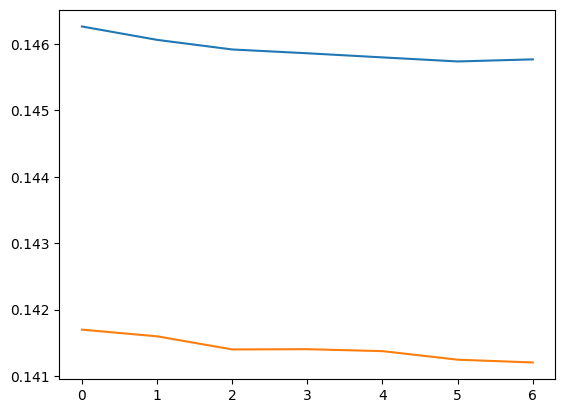

Accuracy : 0.8983050847457628


In [49]:
mlp.train(
    X_train, Y_train,
    X_val, Y_val,
    batch_size = 32,
    num_epochs = E,
    gamma = 0.1,
    weight_decay = 0.01,
    stop_when_not_decreasing=True
)
print(f"""Accuracy : {mlp.accuracy(X_test, Y_test)}""")

In [50]:
maths

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,3,1,0,0,4,4,0,4,...,3,2,3,0,0,2,6,5,6,6
1,0,0,2,1,0,1,1,1,0,2,...,4,2,2,0,0,2,4,5,5,6
2,0,0,0,1,1,1,1,1,0,2,...,3,2,1,1,2,2,10,7,8,10
3,0,0,0,1,0,1,4,2,1,3,...,2,1,1,0,0,4,2,15,14,15
4,0,0,1,1,0,1,3,3,2,2,...,3,2,1,0,1,4,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,5,1,1,0,2,2,3,3,...,4,4,3,3,4,3,11,9,9,9
391,1,1,2,1,1,1,3,1,3,3,...,1,3,4,2,3,1,3,14,16,16
392,1,1,6,0,0,1,1,1,2,2,...,4,4,2,2,2,2,3,10,8,7
393,1,1,3,0,1,1,3,2,3,2,...,3,3,0,2,3,4,0,11,12,10


In [55]:
portugese

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [61]:
portugese = portugese[
    portugese['G1'].map(lambda x : not np.isnan(x))
    & portugese['G2'].map(lambda x : not np.isnan(x))
    & portugese['G3'].map(lambda x : not np.isnan(x))
].reset_index().drop(columns = ['index'])
portugese['G1'] = portugese['G1'].astype(int)
portugese['G2'] = portugese['G2'].astype(int)
portugese['G3'] = portugese['G3'].astype(int)

X_train, Y_train, X_val, Y_val, X_test, Y_test = prepare_datasets(portugese)

ReLU = Activation(relu, relu_gradient)
Sigmoid = Activation(sigmoid, sigmoid_gradient)

MSE = MSELoss()

mlp = MLP(
    dim = [X_train.shape[1], 3, 1],
    activations = [ReLU, Sigmoid],
    loss = MSE
)
mlp.accuracy(X_test, Y_test)

0.5111111111111111

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:04<00:00, 154.06it/s]


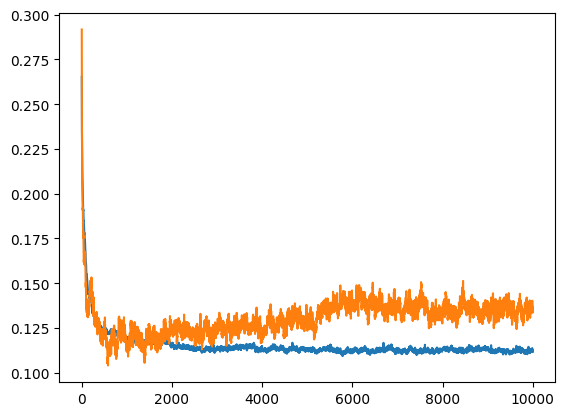

Accuracy : 0.7444444444444445


In [62]:
mlp.train(
    X_train, Y_train,
    X_val, Y_val,
    batch_size = 8,
    num_epochs = 10000,
    gamma = 0.1,
    weight_decay = 0.01,
    stop_when_not_decreasing=False
)
print(f"""Accuracy : {mlp.accuracy(X_test, Y_test)}""")

## Explain overfitting